In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
import random
import cv2
import tensorflow as tf
# from segmentation import build_unet, vgg16_unet, vgg19_unet, resnet50_unet, inception_resnetv2_unet, densenet121_unet
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Dropout
from tensorflow.keras.models import Model
from sklearn.metrics import f1_score

In [2]:
images_folder = os.path.join('../input/sentinel12-image-pairs-segregated-by-terrain/v_2/agri/s2/')
images_folder2 = os.path.join('../input/sentinel12-image-pairs-segregated-by-terrain/v_2/grassland/s2/')
images_folder3 = os.path.join('../input/augmented-forest-segmentation/Forest Segmented/Forest Segmented/images/')
masks_folder = os.path.join('../input/../input/agrimask')
data = pd.read_csv('../input/agrimask/meta_data.csv')

In [3]:
data.head()

,image,mask
0,ROIs1868_summer_s2_59_p2.png,ROIs1868_summer_s2_59_p2_mask.png
1,ROIs1868_summer_s2_59_p3.png,ROIs1868_summer_s2_59_p3_mask.png
2,ROIs1868_summer_s2_59_p4.png,ROIs1868_summer_s2_59_p4_mask.png
3,ROIs1868_summer_s2_59_p5.png,ROIs1868_summer_s2_59_p5_mask.png
4,ROIs1868_summer_s2_59_p6.png,ROIs1868_summer_s2_59_p6_mask.png


In [4]:
images_folder

'../input/sentinel12-image-pairs-segregated-by-terrain/v_2/agri/s2/'

In [74]:
img_dim = 256

In [75]:
ss = "../input/augmented-forest-segmentation/Forest Segmented/Forest Segmented/images"
ss

'../input/augmented-forest-segmentation/Forest Segmented/Forest Segmented/images'

### Splitting the data into Image and target label

In [76]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.model_selection import train_test_split

# Set up your data generators
data_gen_args = dict(
    # Geometric transformations
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,  # You can add vertical flipping for data augmentation
    shear_range=0.2,      # Shear transformations to introduce slant in the image
    # Intensity transformations
    brightness_range=[0.7, 1.3],  # Random brightness adjustments
    channel_shift_range=20,       # Random channel shifts for color augmentation
    # Other options
    fill_mode='nearest'  # Filling mode for handling newly created pixels
)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

In [92]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.utils import shuffle

def input_target_split(data, images_folder, masks_folder, dim):
    data_gen_args = dict(
        # Define your desired data augmentation options
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)

    dataset = []

    for index, row in data.iterrows():
        if "ROIs1970_fall_s2_145" in row['image']:
            image = load_img(os.path.join(images_folder2, row['image']), target_size=(dim, dim))
        elif "ROIs" in row['image']:
            image = load_img(os.path.join(images_folder, row['image']), target_size=(dim, dim))
        else:
            image = load_img(os.path.join(images_folder3, row['image']), target_size=(dim, dim))

        mask = load_img(os.path.join(masks_folder, row['mask']), target_size=(dim, dim), color_mode='grayscale')

        image = img_to_array(image)
        image = image / 255.0

        mask = img_to_array(mask)
        mask = mask / 255.0

        image_array = np.expand_dims(image, axis=0)
        mask_array = np.expand_dims(mask, axis=0)

        # Augment the image and mask and store them in the lists
        for j in range(15):
            augmented_image = image_datagen.flow(image_array, batch_size=1, seed=42 + j).__next__()[0]
            augmented_mask = mask_datagen.flow(mask_array, batch_size=1, seed=42 + j).__next__()[0]
            dataset.append((augmented_image, augmented_mask))

        print(f"\rProgress: {index}", end='')

    dataset = shuffle(dataset, random_state=42)
    X, Y = zip(*dataset)

    return np.array(X), np.array(Y)


In [93]:
X, Y = input_target_split(data,images_folder,masks_folder,img_dim)

Progress: 202

In [102]:
print("Image Dimensions: ",X.shape)
print("Mask Dimensions: ",Y.shape)

Image Dimensions:  (3045, 256, 256, 3)
Mask Dimensions:  (3045, 256, 256, 1)


In [103]:
X_train = X[0:int(len(X)*0.8)]
X_test = X[int(len(X)*0.8):]
Y_train = Y[0:int(len(Y)*0.8)]
Y_test = Y[int(len(Y)*0.8):]

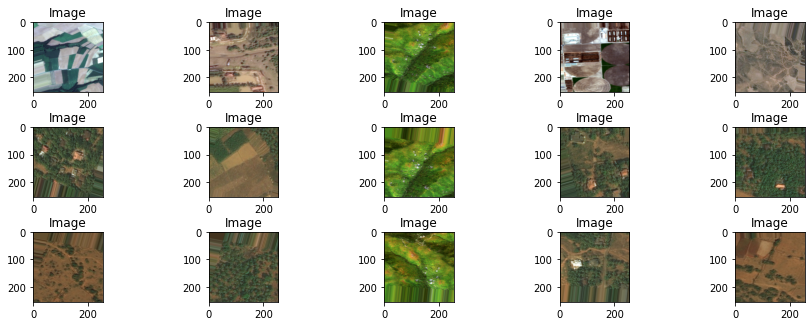

In [98]:
plt.figure(figsize = (15 , 9))
n = 0
for i in range(15):
    n+=1
    plt.subplot(5 , 5, n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
    plt.imshow(X[i+950])
    plt.title('Image')

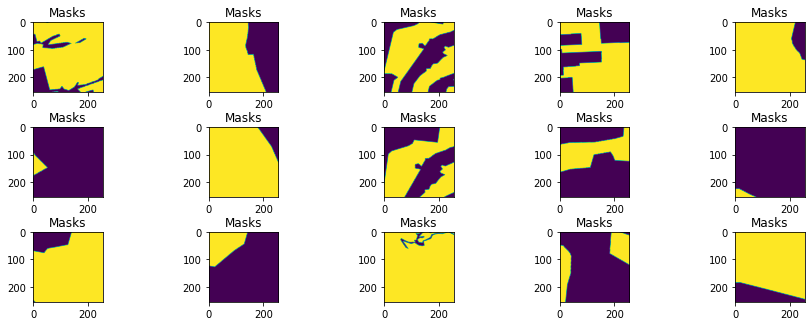

In [101]:
plt.figure(figsize = (15 , 9))
n = 0
for i in range(15):
    n+=1
    plt.subplot(5 , 5, n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
    plt.imshow(Y[i+950])
    plt.title('Masks')

### Splitting the data into train and test images

### Costructing the UNET Architecture

In [70]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)
    s4, p4 = encoder_block(p3, 256)

    b1 = conv_block(p4, 512)

    d1 = decoder_block(b1, s4, 256)
    d2 = decoder_block(d1, s3, 128)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 32)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [104]:
from keras import backend as K
def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def iou_coef_loss(y_true, y_pred):
    return -iou_coef(y_true, y_pred)

def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = label(y_true_in > 0.5)
    y_pred = label(y_pred_in > 0.5)
    
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.array(np.mean(metric), dtype=np.float32)

def my_iou_metric(label, pred):
    metric_value = tf.compat.v1.py_func(iou_metric_batch, [label, pred], tf.float32)
    return metric_value

### Building the Model

In [105]:
input_shape = (img_dim, img_dim, 3)
model = build_unet(input_shape)
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 256, 256, 32) 896         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 256, 256, 32) 128         conv2d_38[0][0]                  
__________________________________________________________________________________________________
activation_36 (Activation)      (None, 256, 256, 32) 0           batch_normalization_36[0][0]     
______________________________________________________________________________________________

### Compiling the model

In [106]:
model.compile(optimizer = tf.keras.optimizers.Adam(lr = 0.0001), loss = ['binary_crossentropy'], metrics=[iou_coef,'accuracy'])

In [107]:
model.input

<KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'input_3')>

In [108]:
model.output

<KerasTensor: shape=(None, 256, 256, 1) dtype=float32 (created by layer 'conv2d_56')>

### Setting early stopping and checkpoint criterion

In [109]:
model_path = "unet.h5"
checkpoint = ModelCheckpoint(model_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 9,
                          verbose = 1,
                          restore_best_weights = True)

In [110]:
X_train.shape

(2436, 256, 256, 3)

In [111]:
Y_train.shape

(2436, 256, 256, 1)

In [113]:
history = model.fit(
    X_train, Y_train,
    batch_size=32,
    validation_data=(X_test, Y_test),
    epochs=50,
    callbacks=[earlystop, checkpoint]
)

Epoch 1/50
77/77 [==============================] - 41s 380ms/step - loss: 0.5401 - iou_coef: 0.4048 - accuracy: 0.7180 - val_loss: 0.8582 - val_iou_coef: 0.4021 - val_accuracy: 0.4752

Epoch 00001: val_loss improved from inf to 0.85819, saving model to unet.h5
Epoch 2/50
77/77 [==============================] - 27s 349ms/step - loss: 0.3833 - iou_coef: 0.4914 - accuracy: 0.8187 - val_loss: 1.8843 - val_iou_coef: 0.4823 - val_accuracy: 0.4752

Epoch 00002: val_loss did not improve from 0.85819
Epoch 3/50
77/77 [==============================] - 27s 347ms/step - loss: 0.3585 - iou_coef: 0.5130 - accuracy: 0.8285 - val_loss: 1.5943 - val_iou_coef: 0.4793 - val_accuracy: 0.4752

Epoch 00003: val_loss did not improve from 0.85819
Epoch 4/50
77/77 [==============================] - 27s 349ms/step - loss: 0.3176 - iou_coef: 0.5449 - accuracy: 0.8513 - val_loss: 1.1582 - val_iou_coef: 0.4647 - val_accuracy: 0.4799

Epoch 00004: val_loss did not improve from 0.85819
Epoch 5/50
77/77 [=========

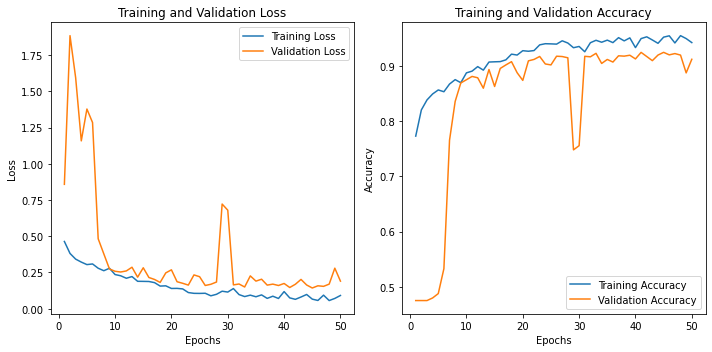

In [125]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Get training history
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']
    training_accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']

    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(training_loss) + 1), training_loss, label='Training Loss')
    plt.plot(range(1, len(validation_loss) + 1), validation_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(training_accuracy) + 1), training_accuracy, label='Training Accuracy')
    plt.plot(range(1, len(validation_accuracy) + 1), validation_accuracy, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Assuming you already have trained your model and have the 'history' variable
plot_training_history(history)


### Visualizing the Results

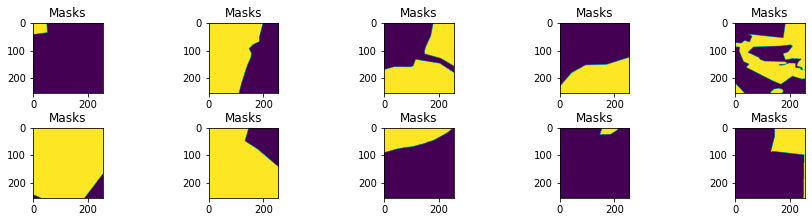

In [114]:
plt.figure(figsize = (15 , 9))
n = 0
for i in range(0,10):
    n+=1
    plt.subplot(5 , 5, n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
    plt.imshow(Y_test[i])
    plt.title('Masks')

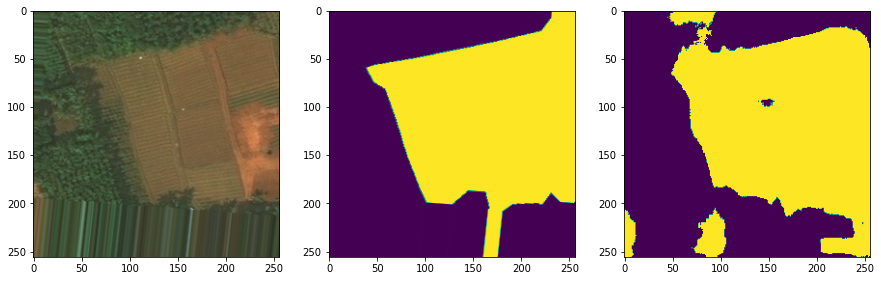

In [123]:
plt.figure(figsize = (15 , 9))
result = model.predict(X_test)
output = result[105]
output[output >= 0.5] = 1
output[output < 0.5] = 0

plt.subplot(1, 3, 1)
plt.imshow(X_test[105])

plt.subplot(1, 3, 2)
plt.imshow(Y_test[105])

plt.subplot(1, 3, 3)
plt.imshow(output)

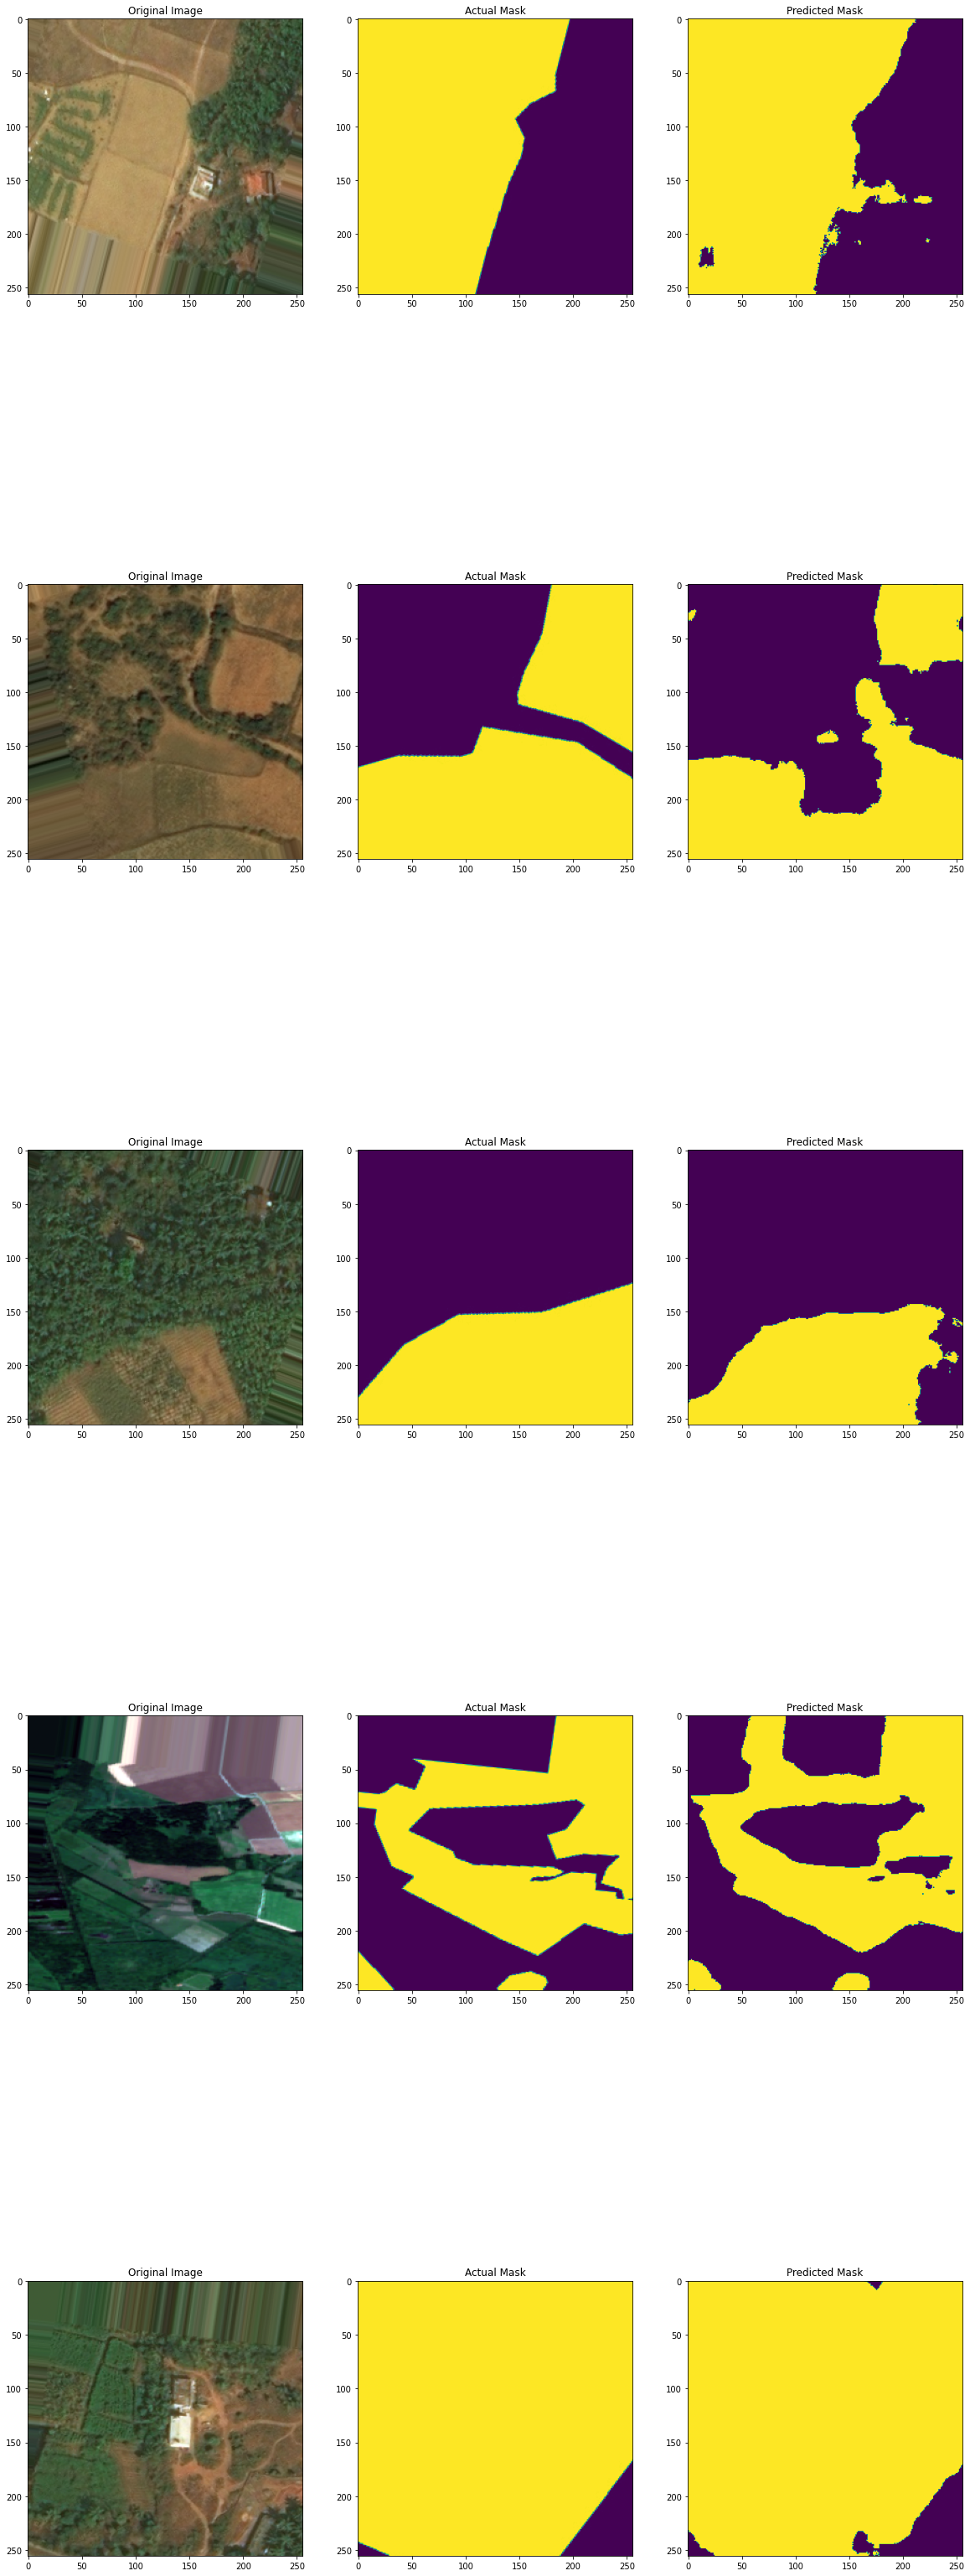

In [124]:
f, axarr = plt.subplots(5,3,figsize=(20, 60))

for i in range(0,5):
    output = result[i+1]
    output[output >= 0.5] = 1
    output[output < 0.5] = 0

    axarr[i,0].imshow(X_test[i+1])
    axarr[i,0].title.set_text('Original Image')
    axarr[i,1].imshow(Y_test[i+1])
    axarr[i,1].title.set_text('Actual Mask')
    axarr[i,2].imshow(output)
    axarr[i,2].title.set_text('Predicted Mask')

## Conclusion
- In some cases the segmented masks do not match with the ground truth mask. The reason behind this is that some of the images were not properly labelled during the data preparation.
- Therefore our model is able to identify certain features that help us segment the forest areas which are not labelled in ground truth images.